**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd, adam
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization
# tf.enable_eager_execution() # Allows to get numpy our of tensor, but breaks the gradients
print(tf.__version__)

Using TensorFlow backend.


2.1.0


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [2]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [3]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

***
In the function ```act```, the agent chooses which action to perform for the next step.

In test mode, it will simply call learned_act and select the best action accordnig to what the agent has learned so far.

In train mode, the action has $\epsilon$ chances to take a random action and $1-\epsilon$ chances to choose the best action according to what it has learned so far. Allowing for random exploration is essential to provent the agent from staying stuck in local minimas in the policy space, and somtimes try actions that are not optimal w.r.t the current learned policy. The basic idea is to introduce exploration not to imbalance it w.r.t exploitation.

(you can use Markdown and Latex)

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [4]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [5]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=100 # set small when debugging
epochs_test=20 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

The ```position``` array indicates the position of the agent, and the available directions for movement: since we do not want the agent to leave the grid, we set to -1 its limits, so that when the agnet receives the cropped cells (before choosing an action), it knows what directions are available to him.

The ```board``` array indicates where the rewards and malus are located: the cells have a positive value if they contain a bonus and a negative value if they contain a malus. Both bonus and malus are randomly distributed accross the grid. Similarily to what is done with the ```position``` array, the grid created is artifucially larger than what it should be, to deal with edge cases.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        # The adjent acts randomly
        a = np.random.randint(0, self.n_action, size=1)[0]

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [7]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        state = env.reset()
        game_over = False
        win = 0
        lose = 0
        
        while not game_over:
            action = agent.act(state)
            previous_state = state
            state, reward, game_over = env.act(action)
            
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [8]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 1.0/1.0. Average score (0.0)
Win/lose count 2.5/4.0. Average score (-0.75)
Win/lose count 2.0/1.0. Average score (-0.16666666666666666)
Win/lose count 0.5/1.0. Average score (-0.25)
Win/lose count 0/3.0. Average score (-0.8)
Win/lose count 1.5/5.0. Average score (-1.25)
Win/lose count 2.0/2.0. Average score (-1.0714285714285714)
Win/lose count 1.0/1.0. Average score (-0.9375)
Win/lose count 2.5/2.0. Average score (-0.7777777777777778)
Win/lose count 2.5/1.0. Average score (-0.55)
Win/lose count 3.5/2.0. Average score (-0.36363636363636365)
Win/lose count 2.0/1.0. Average score (-0.25)
Win/lose count 1.5/3.0. Average score (-0.34615384615384615)
Win/lose count 2.5/3.0. Average score (-0.35714285714285715)
Win/lose count 3.5/3.0. Average score (-0.3)
Win/lose count 1.5/4.0. Average score (-0.4375)
Win/lose count 1.5/1.0. Average score (-0.38235294117647056)
Win/lose count 2.0/3.0. Average score (-0.4166666666666667)
Win/lose count 1.0/3.0. Average score (-0.5)
Win/lose cou

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




***
- Let us prove the first point:
\begin{align*}
Q^\pi(s,a) &= \mathbb{E}_{p^\pi}[\sum_{t=0}^\infty\gamma^tr(s_t, a_t)|s_0=s, a_0=a]\\
&= \mathbb{E}_{p^\pi}[r(s_0,a_0) + \sum_{t=1}^\infty\gamma^tr(s_t, a_t)|s_0=s, a_0=a]\\
&= r(s,a) + \mathbb{E}_{p^\pi}[\sum_{t=1}^\infty\gamma^tr(s_t, a_t)|s_0=s, a_0=a]\\
&= r(s,a) + \mathbb{E}_{p^\pi}[\mathbb{E}_{p^\pi}[\sum_{t=1}^\infty\gamma^tr(s_t, a_t)|s_1,a_1]|s_0=s, a_0=a]\\
&= r(s,a) + \sum_{s',a'}p_\pi(s',a'|s_0,a_0)\mathbb{E}_{p^\pi}[\sum_{t=1}^\infty\gamma^tr(s_t, a_t)|s_1=s',a_1=a']\\
&= r(s,a) + \gamma\sum_{s',a'}p_\pi(s',a'|s_0,a_0)\mathbb{E}_{p^\pi}[\sum_{t=1}^\infty\gamma^{t-1}tr(s_t, a_t)|s_1=s',a_1=a']\\
&= r(s,a) + \gamma\sum_{s',a'}p_\pi(s',a'|s_0,a_0)Q^\pi(s',a')\\
&= \mathbb{E}_{p^\pi}[r(s,a) + \gamma Q^{\pi}(s',a')]
\end{align*}

- Then for the second point, applying the previous equality to $\pi^*$ the optimal policy:
\begin{align*}
Q^*(s,a) &= \mathbb{E}_{s', a'\sim p^{\pi^*}}[r(s,a)+\gamma Q^*(s',a')]\\
&= \mathbb{E}_{s'}[\mathbb{E}_{a'\sim\pi^*}[r(s,a) + \gamma Q^*(s', a')]]\\
\end{align*}
By contradiction, suppose that there exist a state $s'$ and an action $a'$ such that $\pi(a',s')>0$ where $Q^*(s', a')<\max_a Q^*(s', a)$. Then take $\hat{\pi}$ a such that $\hat{\pi}(s,.)=\pi^*(s,.)$ for $s\neq s'$ and $\hat{\pi}(s',a)=\mathbb{1}_{a=argmax_a Q^*(s', a)}$. We then have:
\begin{align*}
\mathbb{E}_{a'\sim\pi^*}[r(s,a) + \gamma Q^*(s', a')]&<\mathbb{E}_{a'\sim\hat{\pi}}[r(s,a) + \gamma Q^*(s', a')]\\
\mathbb{E}_{s'}[\mathbb{E}_{a'\sim\pi^*}[r(s,a) + \gamma Q^*(s', a')]]&<\mathbb{E}_{s'}[\mathbb{E}_{a'\sim\hat{\pi}}[r(s,a) + \gamma Q^*(s', a')]]
\end{align*}
And thus $Q^*(s,a)<Q^{\hat\pi}$, which breaks the definition of $Q^*$.

We thus have that $\forall s, \pi^*(s,a)=\mathbb{1}_{a\in argmax_{a'}}Q^*(s,a')$ and thus:
\begin{align*}
Q^*(s,a) = \mathbb{E}_{s'}[r(s,a) + \gamma\max_{a'}Q^*(s',a')]
\end{align*}

- The intuition for the loss is then the following:

We know that the best policy yields a Q-function that is stable by the optimal Bellman operator (for the Q-function) $\mathcal{B}(f(s,a)) = r(s,a) + \mathbb{E}_{s'}[\max_{a'}f(s',a')]$. The distance between a Q-function and its image by the optimal Bellman operator is thus a mesure of how "good" (ie how close to the optimal solution) our function is.

This distance is then squared to ensure that the problem we are trying to solve is convex.


***

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [9]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory)>self.max_memory:
            self.memory.pop(0)

    def random_access(self):
        index = random.randint(0, len(self.memory)-1)
        return self.memory[index]

***
The pipeline we will use for training is given below:

In [44]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    scores = []

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0
        win_count = 0
        lose_count = 0
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            # win_count and lose_count counts the number of times we landed on good/bad cells
            # To be able to compare exploration strategies to previous results
            if reward > 0:
                win_count += 0.5
                win = win + reward
            if reward < 0:
                if reward < -0.5: lose_count += 1
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose
        scores.append(win_count-lose_count)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return scores

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [45]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):

        input_ = s.reshape(1,5,5,self.n_state)
        q_values = self.model.predict(input_)
        return np.argmax(q_values)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4)) # 4 stands for the number of actions?
        next_states = np.zeros((self.batch_size, 5,5,self.n_state))
        actions = np.zeros((self.batch_size))
        game_overs = np.zeros((self.batch_size))
        rewards = np.zeros((self.batch_size))
        
        for i in range(self.batch_size):
            
            s_, n_s_, a_, r_, game_over = self.memory.random_access()
            input_states[i] = s_
            next_states[i] = n_s_
            actions[i] = a_
            game_overs[i] = game_over_
            rewards[i] = r_
            
        target_q[:] = self.model.predict(input_states)
        next_state_qs = self.model.predict(next_states)
        best_next_state_qs = np.amax(next_state_qs, axis=1)
        actions = actions.astype(int)
        for i in range(self.batch_size):
            target_q[i, actions[i]] = rewards[i] + (1-game_overs[i])*best_next_state_qs[i]
        
            
        
        ######## FILL IN # Did not find anything to add here
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    # Takes as input only the state, and returns one output per action (to be consistent with the code given)
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        
        model = Sequential()
        model.add(Reshape((5*5*self.n_state,), input_shape=(5,5,self.n_state,)))
        model.add(Dense(32, input_dim=5*5*self.n_state, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(4, activation='linear'))
        
        model.compile(adam(lr=lr, decay=1e-4), "mse") # momentum=0.0
        self.model = model
        print(model.summary())
        

2.1.0
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 50)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 132       
Total params: 2,820
Trainable params: 2,820
Non-trainable params: 0
_________________________________________________________________
None
Epoch 000/100 | Loss 0.0604 | Win/lose count 2.0/2.0 (0.0)
Epoch 001/100 | Loss 0.0622 | Win/lose count 3.5/5.0 (-1.5)
Epoch 002/100 | Loss 0.0817 | Win/lose count 2.0/3.0 (-1.0)
Epoch 003/100 | Loss 0.1010 | Win/lose count 2.5/1.0 (1.5)


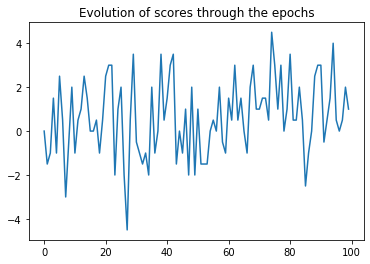

In [46]:
print(tf.__version__)
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=0.0001, epsilon = 0.1, memory_size=2000, batch_size = 32)
scores = train(agent, env, epochs_train, prefix='fc_train')

plt.plot(scores)
plt.title('Evolution of scores through the epochs')
plt.show()
#HTML(display_videos('fc_train10.mp4'))

In [47]:
HTML(display_videos('fc_train90.mp4'))

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [48]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential()
        model.add(Conv2D(8,3, input_shape = (5,5,self.n_state,), padding="same"))
        model.add(Conv2D(8,3, padding="same"))
        model.add(Reshape((5*5*8,), input_shape=(5,5,8,)))
        model.add(Dense(32, input_dim=5*5*8, activation='relu'))
        model.add(Dense(4, activation='linear'))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        print(model.summary())
        
        # Could not find better parameters with adam
        model.compile(sgd(lr=lr, decay=1e-4), "mse") # momentum=0.0
        self.model = model

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 5, 5, 8)           152       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 5, 5, 8)           584       
_________________________________________________________________
reshape_16 (Reshape)         (None, 200)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 132       
Total params: 7,300
Trainable params: 7,300
Non-trainable params: 0
_________________________________________________________________
None
Epoch 000/100 | Loss 1.9900 | Win/lose count 9.0/10.0 (-1.0)
Epoch 001/100 | Loss 1.9489 | Win/lose count 8.5/5.

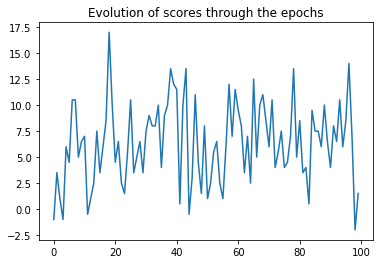

In [49]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
scores = train(agent,env,epochs_train,prefix='cnn_train')

plt.plot(scores)
plt.title('Evolution of scores through the epochs')
plt.show()
#HTML(display_videos('cnn_train10.mp4'))

In [50]:
HTML(display_videos('cnn_train90.mp4'))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [51]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.0001, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 5, 5, 8)           152       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 5, 5, 8)           584       
_________________________________________________________________
reshape_17 (Reshape)         (None, 200)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 132       
Total params: 7,300
Trainable params: 7,300
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_18"
_________________________________________________________________
Layer (type)           

In [52]:
HTML(display_videos('cnn_test10.mp4'))

In [53]:
HTML(display_videos('fc_test10.mp4'))

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [54]:
def train_explore(agent,env,epoch,prefix=''):
    # Decrease epsilon from 0.9 to 0.1 (min is reached at 2/3 of the training)
    # Number of won games
    score = 0
    loss = 0
    scores = []
    
    start_epsilon = 0.5
    end_epsilon = 0.1
    stop = int(epoch*(2/3))
    decrease = (start_epsilon-end_epsilon)/stop
    
    epsilon = start_epsilon
    agent.set_epsilon(epsilon)

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        if e<stop:
            epsilon -= decrease
            agent.set_epsilon(epsilon)
        
        win = 0
        lose = 0
        win_count = 0
        lose_count = 0
        
        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win_count += 0.5
                win = win + reward
            if reward < 0:
                if reward < -0.5: lose_count += 1
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose
        scores.append(win_count-lose_count)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return scores
        
class EnvironmentExploring(Environment):

    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        
        super(EnvironmentExploring, self).__init__(grid_size, max_time, temperature)
        self.malus_position = np.zeros((self.grid_size,self.grid_size))


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        if train:
            reward -= self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.1
        self.board[self.x, self.y] = 0

        game_over = self.t > self.max_time
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]
    
        # Do not forget to reset the position malus
        self.malus_position = np.zeros((self.grid_size,self.grid_size))

        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0
        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        #print(self.board)
        return state
    
'''## use those samples of code:
#In train explore:
state, reward, game_over = env.act(action, train=True)

## In Environment exploring:
# You will have to change n_state to 3 because you will use one more layer!
reward = 0
if train:
    reward = -self.malus_position[self.x, self.y]
self.malus_position[self.x, self.y] = 0.1

reward = reward + self.board[self.x, self.y]
# 3 "feature" states instead of 2
state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)'''

'## use those samples of code:\n#In train explore:\nstate, reward, game_over = env.act(action, train=True)\n\n## In Environment exploring:\n# You will have to change n_state to 3 because you will use one more layer!\nreward = 0\nif train:\n    reward = -self.malus_position[self.x, self.y]\nself.malus_position[self.x, self.y] = 0.1\n\nreward = reward + self.board[self.x, self.y]\n# 3 "feature" states instead of 2\nstate = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),\n                                self.board.reshape(self.grid_size, self.grid_size,1),\n                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)'

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 5, 5, 8)           224       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 5, 8)           584       
_________________________________________________________________
reshape_19 (Reshape)         (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 132       
Total params: 7,372
Trainable params: 7,372
Non-trainable params: 0
_________________________________________________________________
None
Epoch 000/100 | Loss 0.0976 | Win/lose count 3.0/27.600000000000147 (-24.600000000000147)
Epoch 001/100 | Loss 2

Epoch 081/100 | Loss 1.3457 | Win/lose count 19.0/17.299999999999997 (1.7000000000000028)
Epoch 082/100 | Loss 1.3656 | Win/lose count 20.5/15.199999999999976 (5.300000000000024)
Epoch 083/100 | Loss 1.4453 | Win/lose count 21.0/13.499999999999972 (7.500000000000028)
Epoch 084/100 | Loss 1.5232 | Win/lose count 23.0/13.799999999999976 (9.200000000000024)
Epoch 085/100 | Loss 1.2947 | Win/lose count 12.5/16.899999999999974 (-4.399999999999974)
Epoch 086/100 | Loss 1.4146 | Win/lose count 18.0/15.299999999999965 (2.700000000000035)
Epoch 087/100 | Loss 1.4074 | Win/lose count 18.5/13.699999999999974 (4.800000000000026)
Epoch 088/100 | Loss 1.2969 | Win/lose count 15.5/14.899999999999965 (0.6000000000000352)
Epoch 089/100 | Loss 1.0332 | Win/lose count 22.5/13.39999999999998 (9.10000000000002)
Epoch 090/100 | Loss 1.2704 | Win/lose count 16.5/14.99999999999997 (1.5000000000000302)
Epoch 091/100 | Loss 1.1564 | Win/lose count 25.0/14.099999999999977 (10.900000000000023)
Epoch 092/100 | Los

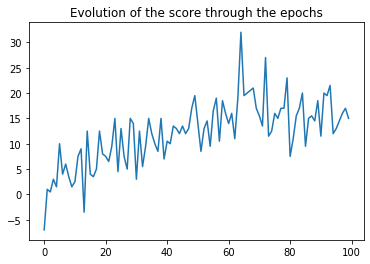

In [55]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
scores = train_explore(agent, env, epochs_train, prefix='cnn_train_explore')

plt.plot(scores)
plt.title('Evolution of the score through the epochs')
plt.show()

#HTML(display_videos('cnn_train_explore10.mp4'))

In [59]:
HTML(display_videos('cnn_train_explore90.mp4'))

In [57]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

Win/lose count 9.5/17.499999999999986. Average score (-7.999999999999986)
Win/lose count 5.5/20.100000000000026. Average score (-11.300000000000006)
Win/lose count 17.5/15.899999999999977. Average score (-6.9999999999999964)
Win/lose count 12.0/17.099999999999984. Average score (-6.524999999999993)
Win/lose count 20.0/17.39999999999999. Average score (-4.699999999999993)
Win/lose count 10.5/18.8. Average score (-5.2999999999999945)
Win/lose count 11.0/16.399999999999967. Average score (-5.314285714285704)
Win/lose count 7.0/18.39999999999999. Average score (-6.07499999999999)
Win/lose count 8.0/19.0. Average score (-6.622222222222214)
Win/lose count 23.5/13.299999999999976. Average score (-4.93999999999999)
Win/lose count 20.0/13.199999999999969. Average score (-3.8727272727272606)
Win/lose count 19.0/15.599999999999964. Average score (-3.266666666666653)
Win/lose count 22.5/14.299999999999969. Average score (-2.3846153846153695)
Win/lose count 20.5/15.499999999999975. Average score (-

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***